In [1]:
import os
import subprocess

java_home = subprocess.check_output(["/usr/libexec/java_home", "-v", "17"]).strip().decode('utf-8')

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = java_home
os.environ["PATH"] = os.path.join(java_home, "bin") + ":" + os.environ["PATH"]
os.environ["PYSPARK_SUBMIT_ARGS"] = "--master local pyspark-shell"

# Verify JAVA_HOME and Java version
print("JAVA_HOME:", os.environ['JAVA_HOME'])
!java -version

JAVA_HOME: /opt/homebrew/Cellar/openjdk@17/17.0.13/libexec/openjdk.jdk/Contents/Home
openjdk version "17.0.13" 2024-10-15
OpenJDK Runtime Environment Homebrew (build 17.0.13+0)
OpenJDK 64-Bit Server VM Homebrew (build 17.0.13+0, mixed mode, sharing)


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .appName("CBRFSS") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()



24/11/28 23:51:11 WARN Utils: Your hostname, MacBook-Air-von-Linda.local resolves to a loopback address: 127.0.0.1; using 10.89.101.139 instead (on interface en0)
24/11/28 23:51:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/28 23:51:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
file_path = "output/processedv2.parquet"

df = spark.read.parquet(file_path)
# df.printSchema()
df.show(30)

+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|GENHLTH|_AGEG5YR|_RFHYPE6|EMPLOY1|_MICHD|_DRDXAR2|_HCVU653|_RFCHOL3|METVL12_|ALCDAY4|_BMI5CAT|DIFFWALK|_TOTINDA|EDUCA|_INCOMG1|CHCKDNY2|FALL12MN|SMOKE100|CVDINFR4|  y|
+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|    4.0|    11.0|     2.0|    1.0|   2.0|     1.0|     9.0|     1.0|   103.0|  888.0|     2.0|     1.0|     1.0|  5.0|     4.0|     2.0|    88.0|     1.0|     2.0|  0|
|    2.0|     9.0|     1.0|    2.0|   2.0|     2.0|     1.0|     2.0|   106.0|  220.0|     2.0|     2.0|     1.0|  6.0|     5.0|     2.0|     2.0|     2.0|     2.0|  0|
|    3.0|     8.0|     1.0|    1.0|   2.0|     2.0|     1.0|     1.0|   104.0|  210.0|     4.0|     2.0|     1.0|  6.0|     5.0|     2.0|    88.0|     2.0|

In [7]:
df.printSchema()

root
 |-- GENHLTH: double (nullable = true)
 |-- _AGEG5YR: double (nullable = true)
 |-- _RFHYPE6: double (nullable = true)
 |-- EMPLOY1: double (nullable = true)
 |-- _MICHD: double (nullable = true)
 |-- _DRDXAR2: double (nullable = true)
 |-- _HCVU653: double (nullable = true)
 |-- _RFCHOL3: double (nullable = true)
 |-- METVL12_: double (nullable = true)
 |-- ALCDAY4: double (nullable = true)
 |-- _BMI5CAT: double (nullable = true)
 |-- DIFFWALK: double (nullable = true)
 |-- _TOTINDA: double (nullable = true)
 |-- EDUCA: double (nullable = true)
 |-- _INCOMG1: double (nullable = true)
 |-- CHCKDNY2: double (nullable = true)
 |-- FALL12MN: double (nullable = true)
 |-- SMOKE100: double (nullable = true)
 |-- CVDINFR4: double (nullable = true)
 |-- y: integer (nullable = true)



In [8]:
num_columns = len(df.columns)

num_rows = df.count()
# Print the dimensions
print(f"Dimensions of DataFrame: {num_rows} rows, {num_columns} columns")

Dimensions of DataFrame: 251504 rows, 20 columns


We will split the data into 80-20 train and test set and use cross validation

In [9]:
df_filled = df.fillna(0)
train_df, test_df = df_filled.randomSplit([0.8, 0.2], seed=1)
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 201155
Test set count: 50349


In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare feature columns by removing the target variable 'y'
feature_columns = df.columns
feature_columns.remove("y")

# Step 1: Assemble features into a single vector for training data
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_df)

lr = LinearRegression(featuresCol="features", labelCol="y")

# Step 3: Set up Cross-Validation
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.1, 0.01, 0.001])
    .addGrid(lr.elasticNetParam, [0.0,0.001,0.01,0.1, 0.5])
    .build()
)

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="y", metricName="rmse"),
    numFolds=5,
)  # Use 5+ folds for cross-validation

# Train the model using Cross-Validation on the training data
cv_model = crossval.fit(train_data)

# Step 4: Evaluate on Test Set
test_data = assembler.transform(test_df)
test_predictions = cv_model.transform(test_data)

# Evaluate the model performance on test data
evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse"
)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {test_rmse}")

# Optional: Show best model parameters from cross-validation
best_model = cv_model.bestModel
print(f"Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
print(f"Best Elastic Net Parameter: {best_model._java_obj.getElasticNetParam()}")

24/11/28 23:52:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/11/28 23:52:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/11/28 23:52:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/11/28 23:52:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Squared Error (RMSE) on test data: 0.3624568576736904
Best Regularization Parameter: 0.001
Best Elastic Net Parameter: 0.0


In [12]:
threshold = 0.5

# Convert predictions to binary classes based on threshold
test_predictions = test_predictions.withColumn(
    "prediction_class", F.when(test_predictions["prediction"] > threshold, 1.0).otherwise(0.0)
)

# Assuming you have true labels in a column named "true_class"
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate precision and accuracy
classification_evaluator = MulticlassClassificationEvaluator(
    labelCol="y", predictionCol="prediction_class"
)

accuracy = classification_evaluator.evaluate(
    test_predictions, {classification_evaluator.metricName: "accuracy"}
)
precision = classification_evaluator.evaluate(
    test_predictions, {classification_evaluator.metricName: "weightedPrecision"}
)

print(f"Accuracy on test data: {accuracy}")
print(f"Precision on test data: {precision}")

Accuracy on test data: 0.815666646805299
Precision on test data: 0.7682808732030133


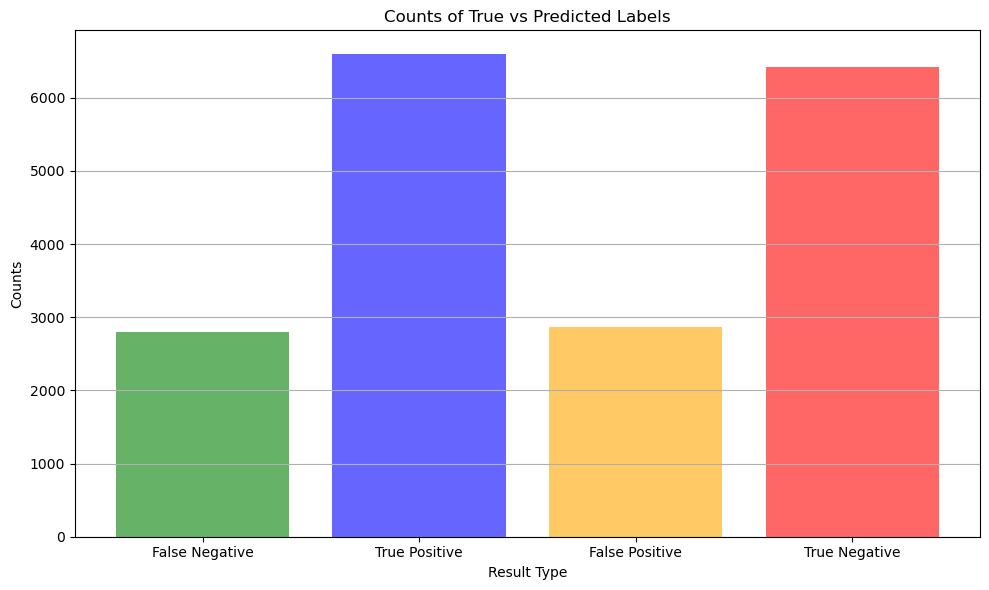

In [28]:
from pyspark.sql.functions import round, when
import matplotlib.pyplot as plt

test_predictions = test_predictions.withColumn(
    "pred_class",
    F.when(test_predictions["prediction"] > threshold, 1.0).otherwise(0.0),
)

# Create a new column for classification results
results_table = test_predictions.select("y", "pred_class")

# Categorize results into True Positive, True Negative, False Positive, False Negative
results_summary = results_table.groupBy(
    when(
        (results_table["y"] == 1) & (results_table["pred_class"] == 1), "True Positive"
    )
    .when(
        (results_table["y"] == 0) & (results_table["pred_class"] == 0), "True Negative"
    )
    .when(
        (results_table["y"] == 0) & (results_table["pred_class"] == 1), "False Positive"
    )
    .when(
        (results_table["y"] == 1) & (results_table["pred_class"] == 0), "False Negative"
    )
    .otherwise("Other")
    .alias("Result")
).count()


# Convert to Pandas DataFrame for better display and plotting
summary_pd = results_summary.toPandas()

# Plotting the counts as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    summary_pd["Result"],
    summary_pd["count"],
    color=["green", "blue", "orange", "red"],
    alpha=0.6,
)

plt.title("Counts of True vs Predicted Labels")
plt.xlabel("Result Type")
plt.ylabel("Counts")
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
def count_entries_with_value(df, column_name, value):
    """
    Count how many entries in the specified column of the DataFrame have the given value.

    :param df: PySpark DataFrame
    :param column_name: Name of the column to check
    :param value: Value to count in the specified column
    :return: Count of entries with the specified value
    """
    count = df.filter(df[column_name] == value).count()
    return count


# Sample data for demonstration
print(count_entries_with_value(test_df, "y", 1))


9347


In [15]:
print(summary_pd)

           Result  count
0  False Negative   8908
1  False Positive    373
2   True Positive    439
3   True Negative  40629


In [16]:
best_model = cv_model.bestModel

# Print trained parameters
print(f"Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
print(f"Best Elastic Net Parameter: {best_model._java_obj.getElasticNetParam()}")
print(f"Coefficients: {best_model.coefficients}")
print(f"Intercept: {best_model.intercept}")

Best Regularization Parameter: 0.001
Best Elastic Net Parameter: 0.0
Coefficients: [0.05142640813671729,0.0006308431826689612,0.054660226780683746,0.004643817001235334,-0.06821939241499742,0.00270036699919938,0.001308153024529371,0.0231078468351563,-0.0003129603538371914,8.59542351393173e-05,0.06456595379080031,-0.01610925430727142,-0.0021223376966876474,-0.007315827478435005,-0.002460737214729918,-0.03969044662693853,-0.00021688744742279315,0.0015999304797944965,-0.020177433940209807]
Intercept: 0.009464156799243709


We notice that a lot of false negatives have been invoked. The reason for that may be because the dataset has far more rows with y = 0 than y = 1. Thus, we ran the same experiment again with a 50/50 split. 

In [17]:
from pyspark.sql.functions import col

df_y_1 = df.filter(col("y") == 1)
df_y_0 = df.filter(col("y") == 0)

In [18]:
num_samples = min(df_y_1.count(), df_y_0.count())  # Get the minimum count

sampled_y_1 = df_y_1.sample(
    False, num_samples / df_y_1.count(), seed=42
)  # Randomly sample from y=1
sampled_y_0 = df_y_0.sample(
    False, num_samples / df_y_0.count(), seed=42
)  # Randomly sample from y=0

# Step 3: Union the sampled DataFrames
new_df = sampled_y_1.union(sampled_y_0)

# Show the result
new_df.show()

+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|GENHLTH|_AGEG5YR|_RFHYPE6|EMPLOY1|_MICHD|_DRDXAR2|_HCVU653|_RFCHOL3|METVL12_|ALCDAY4|_BMI5CAT|DIFFWALK|_TOTINDA|EDUCA|_INCOMG1|CHCKDNY2|FALL12MN|SMOKE100|CVDINFR4|  y|
+-------+--------+--------+-------+------+--------+--------+--------+--------+-------+--------+--------+--------+-----+--------+--------+--------+--------+--------+---+
|    4.0|    13.0|     2.0|    7.0|   2.0|     1.0|     9.0|     2.0|   104.0|  888.0|     4.0|     1.0|     1.0|  6.0|     2.0|     1.0|    88.0|     1.0|     2.0|  1|
|    3.0|     7.0|     2.0|    1.0|   2.0|     2.0|     1.0|     2.0|   103.0|  888.0|     4.0|     1.0|     1.0|  4.0|     2.0|     2.0|    88.0|     1.0|     2.0|  1|
|    2.0|    12.0|     2.0|    7.0|   2.0|     1.0|     9.0|     2.0|   103.0|  203.0|     4.0|     1.0|     1.0|  6.0|     6.0|     2.0|    88.0|     1.0|

In [19]:
num_columns = len(new_df.columns)

num_rows = new_df.count()
# Print the dimensions
print(f"Dimensions of DataFrame: {num_rows} rows, {num_columns} columns")

Dimensions of DataFrame: 93189 rows, 20 columns


In [20]:
df_filled = df.fillna(0)
train_df, test_df = new_df.randomSplit([0.8, 0.2], seed=1)
# Show the counts of each split
print(f"Training set count: {train_df.count()}")
print(f"Test set count: {test_df.count()}")

Training set count: 74501
Test set count: 18688


In [21]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Prepare feature columns by removing the target variable 'y'
feature_columns = new_df.columns
feature_columns.remove("y")

# Step 1: Assemble features into a single vector for training data
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_data = assembler.transform(train_df)

lr = LinearRegression(featuresCol="features", labelCol="y")

# Step 3: Set up Cross-Validation
paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.1, 0.01, 0.001])
    .addGrid(lr.elasticNetParam, [0.0, 0.001, 0.01, 0.1, 0.5])
    .build()
)

crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="y", metricName="rmse"),
    numFolds=5,
)  # Use 5+ folds for cross-validation

# Train the model using Cross-Validation on the training data
cv_model = crossval.fit(train_data)

# Step 4: Evaluate on Test Set
test_data = assembler.transform(test_df)
test_predictions = cv_model.transform(test_data)

# Evaluate the model performance on test data
evaluator = RegressionEvaluator(
    labelCol="y", predictionCol="prediction", metricName="rmse"
)
test_rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {test_rmse}")

# Optional: Show best model parameters from cross-validation
best_model = cv_model.bestModel
print(f"Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
print(f"Best Elastic Net Parameter: {best_model._java_obj.getElasticNetParam()}")

Root Mean Squared Error (RMSE) on test data: 0.4471374930375396
Best Regularization Parameter: 0.001
Best Elastic Net Parameter: 0.0


In [22]:
threshold = 0.5

# Convert predictions to binary classes based on threshold
test_predictions = test_predictions.withColumn(
    "prediction_class",
    F.when(test_predictions["prediction"] > threshold, 1.0).otherwise(0.0),
)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate precision and accuracy
classification_evaluator = MulticlassClassificationEvaluator(
    labelCol="y", predictionCol="prediction_class"
)

accuracy = classification_evaluator.evaluate(
    test_predictions, {classification_evaluator.metricName: "accuracy"}
)
precision = classification_evaluator.evaluate(
    test_predictions, {classification_evaluator.metricName: "weightedPrecision"}
)

print(f"Accuracy on test data: {accuracy}")
print(f"Precision on test data: {precision}")

Accuracy on test data: 0.696650256849315
Precision on test data: 0.6966515722959987


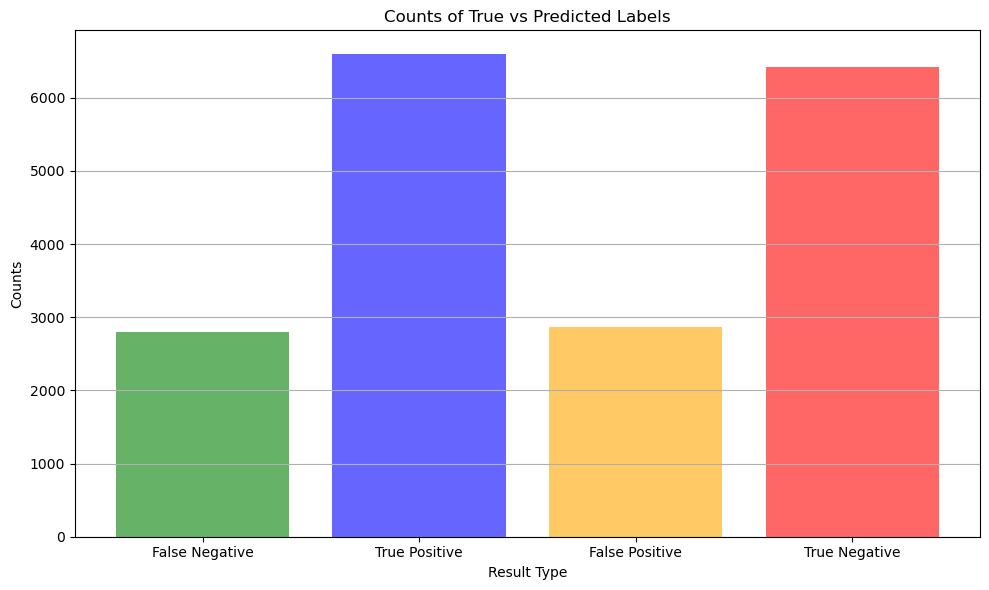

In [29]:
from pyspark.sql.functions import round, when
import matplotlib.pyplot as plt

test_predictions = test_predictions.withColumn(
    "pred_class",
    F.when(test_predictions["prediction"] > threshold, 1.0).otherwise(0.0),
)

# Create a new column for classification results
results_table = test_predictions.select("y", "pred_class")

# Categorize results into True Positive, True Negative, False Positive, False Negative
results_summary = results_table.groupBy(
    when(
        (results_table["y"] == 1) & (results_table["pred_class"] == 1), "True Positive"
    )
    .when(
        (results_table["y"] == 0) & (results_table["pred_class"] == 0), "True Negative"
    )
    .when(
        (results_table["y"] == 0) & (results_table["pred_class"] == 1), "False Positive"
    )
    .when(
        (results_table["y"] == 1) & (results_table["pred_class"] == 0), "False Negative"
    )
    .otherwise("Other")
    .alias("Result")
).count()


# Convert to Pandas DataFrame for better display and plotting
summary_pd = results_summary.toPandas()

# Plotting the counts as a bar plot
plt.figure(figsize=(10, 6))
plt.bar(
    summary_pd["Result"],
    summary_pd["count"],
    color=["green", "blue", "orange", "red"],
    alpha=0.6,
)

plt.title("Counts of True vs Predicted Labels")
plt.xlabel("Result Type")
plt.ylabel("Counts")
plt.grid(axis="y")

# Show the plot
plt.tight_layout()
plt.show()

In [30]:
print(summary_pd)
best_model = cv_model.bestModel

# Print trained parameters
print(f"Best Regularization Parameter: {best_model._java_obj.getRegParam()}")
print(f"Best Elastic Net Parameter: {best_model._java_obj.getElasticNetParam()}")
print(f"Coefficients: {best_model.coefficients}")
print(f"Intercept: {best_model.intercept}")

           Result  count
0  False Negative   2796
1   True Positive   6593
2  False Positive   2873
3   True Negative   6426
Best Regularization Parameter: 0.001
Best Elastic Net Parameter: 0.0
Coefficients: [0.08856095221752161,0.007559743536398449,0.09694772143817115,0.006235964702065926,-0.07894444230575781,0.006535969223911723,0.0023111754318209587,0.033943141238548497,-0.0003985207166023812,0.00013846028702862927,0.11135308654727981,-0.00931879475575499,-0.0032277322256620564,-0.011115690287531827,-0.003516167543995681,-0.03632249039365997,-0.00026464087401275677,0.0030300691994269934,-0.011222721473528121]
Intercept: -0.16019738567876618
